In [1]:
from collections import defaultdict
import json
from pathlib import Path
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from clip_layerwise_alignment.config import LOCAL_DATA_DIR, LOCAL_MODELS_DIR

In [2]:
def _check_features_matching(data_a, data_b, captions_per_image=5):
    metadata = data_a["metadata"]

    # Verify we have matching filenames for both layers
    assert (
        data_a["metadata"]["filenames"] == data_b["metadata"]["filenames"]
    ), "Metadata ordering mismatch between projected and final features!"

    # Count unique images to sample from
    n_unique_images = len(set(metadata["filenames"]))
    assert n_unique_images * captions_per_image == len(
        metadata["filenames"]
    )  # if not 5 captions per image, the sampling wont work

    return n_unique_images


def _calculate_loss(
    features_a, features_b, temp, n_unique_images, batch_size=256, captions_per_image=5
):
    images_idx = random.sample(range(n_unique_images), batch_size)
    features_idx = [
        (x * captions_per_image) + random.randint(0, (captions_per_image - 1)) for x in images_idx
    ]

    projected_samples = [features_a[idx] for idx in features_idx]  # Every 5th sample
    projected_batch = torch.stack(projected_samples)
    final_samples = [features_b[idx] for idx in features_idx]
    final_batch = torch.stack(final_samples)

    text_norm = F.normalize(projected_batch, dim=-1)
    image_norm = F.normalize(final_batch, dim=-1)

    logits = (image_norm @ text_norm.T) / temp
    labels = torch.arange(256)

    loss_i2t = F.cross_entropy(logits, labels)
    loss_t2i = F.cross_entropy(logits.T, labels)
    loss = (loss_i2t + loss_t2i) / 2

    return loss

In [3]:
n_batches = 100
batch_size = 256

results_folder = LOCAL_DATA_DIR / "results" / "flickr30k"

In [4]:
# =========================================
# Calculate pretrained loss
# =========================================
pretrained_losses = []
text_final_data = torch.load(results_folder / f"text_final.pt")
text_final_embeddings = text_final_data["features"]

image_final_data = torch.load(results_folder / f"image_final.pt")
image_final_embeddings = image_final_data["features"]

temp = 0.07

n_unique_images = _check_features_matching(text_final_data, image_final_data)

for _ in range(n_batches):
    loss = _calculate_loss(
        text_final_embeddings, image_final_embeddings, temp, n_unique_images, batch_size
    )
    pretrained_losses.append(loss.item())

In [5]:
# =========================================
# Calculate projection loss
# =========================================
losses = {
    "image": defaultdict(list),
    "text": defaultdict(list),
}  # nested dicts: {1: [loss_1, loss_2, ...]}
for projected_encoder in ["text", "image"]:
    for L in range(1, 13):
        # Load the required embeddings + metadata
        if projected_encoder == "text":
            projected_data = torch.load(results_folder / f"text_L{L}_image_final_projected.pt")
            projected_features = projected_data["text_embeddings"]

            final_data = torch.load(results_folder / f"image_final.pt")
            final_features = final_data["features"]

            checkpoint = torch.load(LOCAL_MODELS_DIR / f"projections/text_L{L}_image_final.pt")
            inv_log_temp = checkpoint["model_state_dict"]["log_temperature"]
            temp = 1 / inv_log_temp.exp()

        else:  # projected_encoder == "image"
            projected_data = torch.load(results_folder / f"text_final_image_L{L}_projected.pt")
            projected_features = projected_data["image_embeddings"]

            final_data = torch.load(results_folder / f"text_final.pt")
            final_features = final_data["features"]

            checkpoint = torch.load(LOCAL_MODELS_DIR / f"projections/text_final_image_L{L}.pt")
            inv_log_temp = checkpoint["model_state_dict"]["log_temperature"]
            temp = 1 / inv_log_temp.exp()

        n_unique_images = _check_features_matching(final_data, projected_data)

        # Calculate loss for n_samples random batches
        for _ in range(n_batches):
            loss = _calculate_loss(
                projected_features, final_features, temp, n_unique_images, batch_size
            )

            losses[projected_encoder][L].append(loss.item())

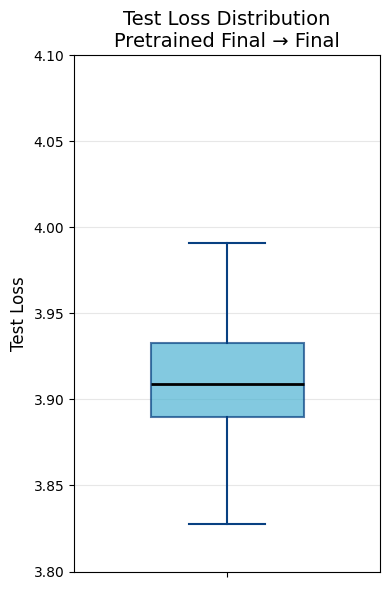

In [18]:
def plot_pretrained_loss_distribution(
    pretrained_losses: list,  # List of loss values
    box_color: str = '#4eb3d3',
    box_edge_color: str = '#084081',
):
    """
    Plot box plot of pretrained final×final test losses.
    
    Args:
        pretrained_losses: List of loss values from final×final comparisons
        box_color: Color for the box
        box_edge_color: Color for box border
    """
    fig, ax = plt.subplots(figsize=(4, 6))
    
    bp = ax.boxplot(
        [pretrained_losses],
        positions=[1],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor=box_color, alpha=0.7, edgecolor=box_edge_color, linewidth=1.5),
        medianprops=dict(color='black', linewidth=2),
        whiskerprops=dict(color=box_edge_color, linewidth=1.5),
        capprops=dict(color=box_edge_color, linewidth=1.5),
        flierprops=dict(marker='.', markerfacecolor=box_edge_color, markersize=8, linestyle='none'),
    )
    
    ax.set_ylabel('Test Loss', fontsize=12)
    ax.set_title('Test Loss Distribution\nPretrained Final → Final', fontsize=14)
    ax.set_xticks([1])
    ax.set_xticklabels([''])
    ax.set_ylim(3.8, 4.1)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    return fig

# Usage:
fig = plot_pretrained_loss_distribution(pretrained_losses)
plt.savefig("pretrained_loss_distribution.png", dpi=150)
plt.show()

In [6]:
def plot_test_loss_distribution(
    losses: dict,
    projected_encoder: str,  # "text" or "image"
    box_color: str = '#3498db',
    box_edge_color: str = '#2c3e50',
    mean_pretrained_loss: float = None,  # Add this parameter
):
    """
    Plot box plot of test losses for each layer projection.
    
    Args:
        losses: Dict with structure {encoder: {layer: [loss_1, loss_2, ...]}}
        projected_encoder: "text" or "image"
        box_color: Color for the boxes
        box_edge_color: Color for box borders
    """
    layers = sorted(losses[projected_encoder].keys())
    loss_data = [losses[projected_encoder][L] for L in layers]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bp = ax.boxplot(
        loss_data,
        positions=layers,
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=box_color, alpha=0.7, edgecolor=box_edge_color, linewidth=1.5),
        medianprops=dict(color='black', linewidth=2),
        whiskerprops=dict(color=box_edge_color, linewidth=1.5),
        capprops=dict(color=box_edge_color, linewidth=1.5),
        flierprops=dict(marker='.', markerfacecolor=box_edge_color, markersize=8, linestyle='none'),
    )
    
    # Add horizontal line for pretrained baseline
    if mean_pretrained_loss is not None:
        ax.axhline(y=mean_pretrained_loss, color='black', linestyle='--', linewidth=1.5, 
                   zorder=0, label='Pretrained Final×Final')
        ax.text(max(layers), mean_pretrained_loss, f' Mean pretrained loss (final to final): {mean_pretrained_loss:.2f}', 
                va='bottom', ha='right', fontsize=10, color='black')
    
    target_encoder = "text" if projected_encoder == "image" else "image"

    target_encoder = "text" if projected_encoder == "image" else "image"
    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel('Test Loss', fontsize=12)
    ax.set_title(f'Test Loss Distribution: {projected_encoder.capitalize()} Encoder Layer Projections → {target_encoder.capitalize()} Final', 
                 fontsize=14)
    ax.set_xticks(layers)
    ax.set_xticklabels([f'L{L}' for L in layers])
    ax.set_ylim(0, 5.5)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    return fig

In [7]:
mean_pretrained_loss = np.array(pretrained_losses).mean()

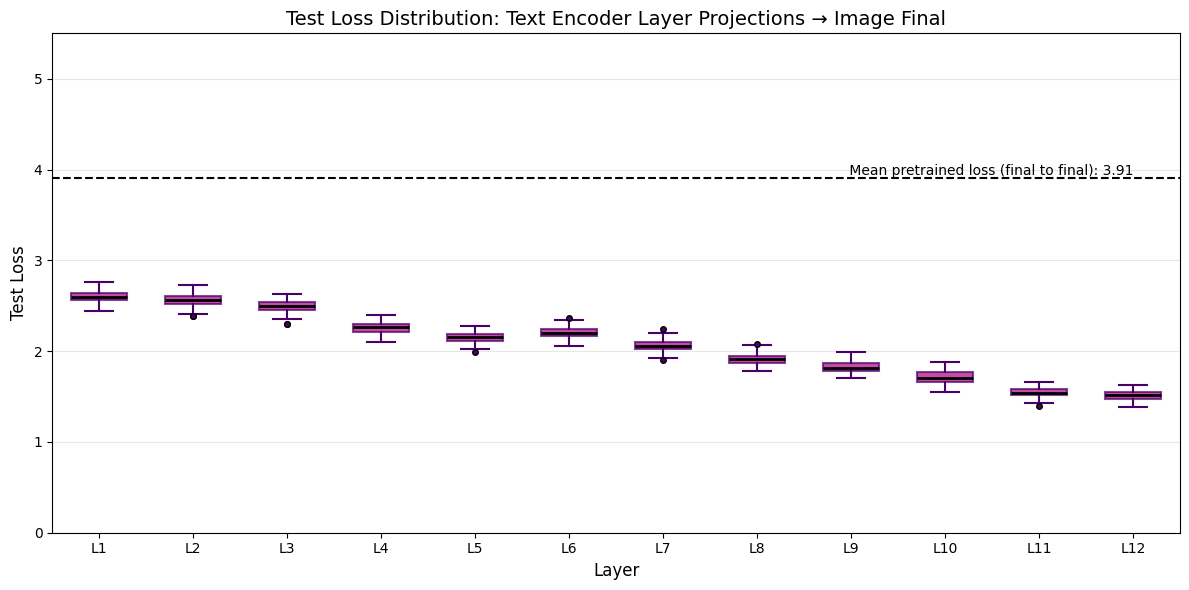

In [12]:
# Usage:
fig_text = plot_test_loss_distribution(
    losses,
    "text",
    box_color="#ae017e",
    box_edge_color="#49006a",
    mean_pretrained_loss=mean_pretrained_loss,
)
plt.savefig("test_loss_text_projections.png", dpi=300)
plt.show()

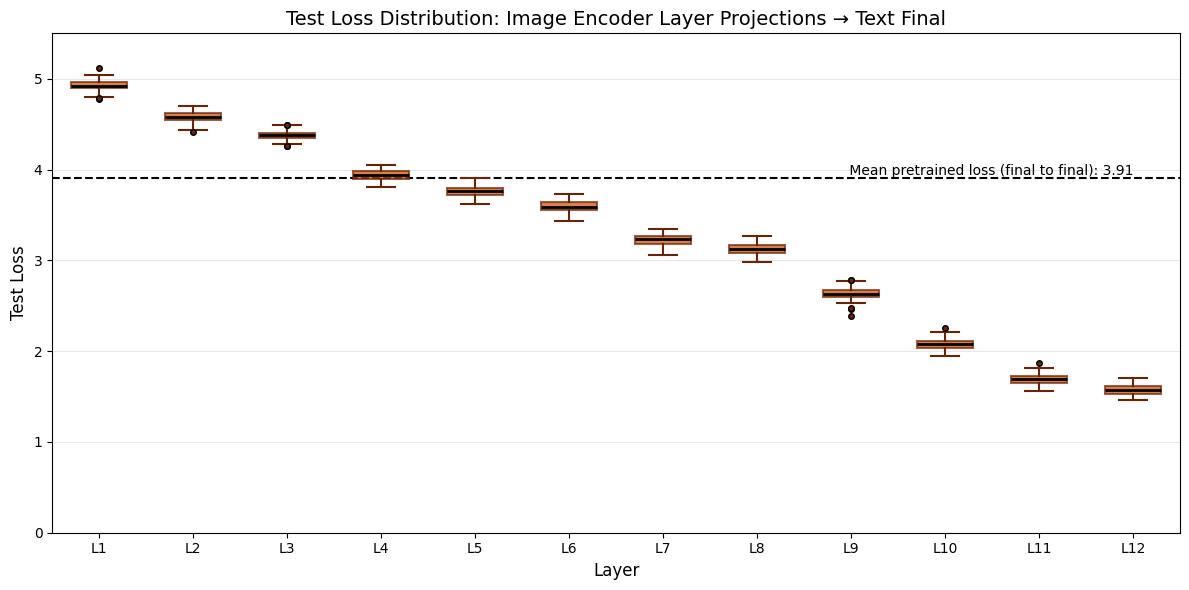

In [13]:
# Usage:
fig_text = plot_test_loss_distribution(
    losses,
    "image",
    box_color="#cc4c02",
    box_edge_color="#662506",
    mean_pretrained_loss=mean_pretrained_loss,
)
plt.savefig("test_loss_text_projections.png", dpi=300)
plt.show()